In [38]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


month = '2016-09-01'
sql = """SELECT * FROM (
  SELECT
    month,
    pct,
    pmean,
    p50th,
    RANK() OVER (PARTITION BY month ORDER BY p50th ASC) AS p_rank
  FROM (
    SELECT
      month,
      pct,
      MAX(p_count) AS pcount,
      MAX(p_average) AS pmean,
      MAX(p_50th) AS p50th
    FROM (
      SELECT
        month,
        pct,
        COUNT(*) OVER (PARTITION BY month, pct ORDER BY ppq ASC) AS p_count,
        AVG(ppq) OVER (PARTITION BY month, pct) AS p_average,
        PERCENTILE_CONT(0.5) OVER (PARTITION BY month, pct ORDER BY ppq ASC) AS p_50th
      FROM (
        SELECT
          month,
          pct,
          net_cost/quantity AS ppq
        FROM
          [ebmdatalab:hscic.prescribing] AS p
        LEFT JOIN ebmdatalab.hscic.practices practices
          ON p.practice = practices.code
        WHERE
          practices.setting = 4 AND
          bnf_code LIKE '0601060D0%'))
    GROUP BY
      month,
        pct) 
        
ORDER BY
  month, p_rank
)"""
df = pd.io.gbq.read_gbq(
        sql, project_id="ebmdatalab", verbose=False, dialect='legacy')

Populating the interactive namespace from numpy and matplotlib


In [39]:
df.head()

,month,pct,pmean,p50th,p_rank
0,2010-08-01,5PG,0.294827,0.2946,1
1,2010-08-01,5C3,0.294724,0.2946,1
2,2010-08-01,5HX,0.294748,0.2946,1
3,2010-08-01,5EF,0.295261,0.2946,1
4,2010-08-01,5D9,0.294294,0.2946,1


In [50]:
interest = df[(df.pct == '99P') | (df.pct == '99F')]
interest = interest.set_index('month')
interest.head()

,pct,pmean,p50th,p_rank
month,,,,
2013-04-01,99F,0.284267,0.3040,4
2013-04-01,99P,0.300800,0.3054,29
2013-05-01,99F,0.282503,0.3022,3
2013-05-01,99P,0.289747,0.3054,32
2013-06-01,99F,0.282510,0.3022,4


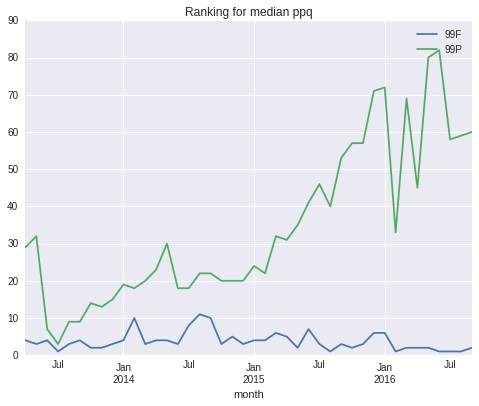

In [51]:

fig, ax = plt.subplots(figsize=(8,6))
for label, sdf in interest.groupby('pct'):
    sdf.p_rank.plot(ax=ax, label=label)
plt.legend()
plt.title("Ranking for median ppq")
plt.show()


#sns.tsplot(interest, time='month', value='p50th', condition='pct')